# Download Dataset

In [1]:
from google.colab import files, output
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"usupal","key":"8cf51244cd302946f9df4365761cf3a7"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/

# change permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# !mkdir Coronahack-Chest-XRay-Dataset
# %cd Coronahack-Chest-XRay-Dataset

In [5]:
!kaggle datasets download praveengovi/coronahack-chest-xraydataset


100% 1.19G/1.19G [00:09<00:00, 147MB/s]
100% 1.19G/1.19G [00:09<00:00, 135MB/s]


In [6]:
#!kaggle datasets download mlg-ulb/creditcardfraud

In [7]:
%pwd

'/content'

In [8]:
! unzip coronahack-chest-xraydataset.zip
output.clear()

In [9]:
# remove zipped dataset
!rm coronahack-chest-xraydataset.zip

# Import Libraries

In [10]:
# Common lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Utils
from tqdm import tqdm
import datetime

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, auc

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print("Import successfully")

Import successfully


# EDA

In [11]:
# Init variables
input_folder = '/content/Coronahack-Chest-XRay-Dataset'
test_img_folder = os.path.join(input_folder,'Coronahack-Chest-XRay-Dataset', 'test')
train_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'train')
metadata_df = pd.read_csv(('/content/Chest_xray_Corona_Metadata.csv'), index_col=0)

In [12]:
metadata_df.describe()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
count,5910,5910,5910,69,4334
unique,5910,2,2,4,3
top,person1312_bacteria_3319.jpeg,Pnemonia,TRAIN,COVID-19,bacteria
freq,1,4334,5286,58,2777


In [13]:
# Split to train & test set
train_df = metadata_df[metadata_df.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_df = metadata_df[metadata_df.Dataset_type == 'TEST'].reset_index(drop=True)

# Check train_df size + test_df size == metadata_df size
assert train_df.size + test_df.size == metadata_df.size

print(f'Shape of train data: { train_df.shape }')
print(f'Shape of test data: { test_df.shape }')

train_df.sample(10)

Shape of train data: (5286, 5)
Shape of test data: (624, 5)


,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
3924,person515_bacteria_2187.jpeg,Pnemonia,TRAIN,NaN,bacteria
11,IM-0182-0001.jpeg,Normal,TRAIN,NaN,NaN
408,IM-0553-0001-0001.jpeg,Normal,TRAIN,NaN,NaN
1765,person1202_bacteria_3153.jpeg,Pnemonia,TRAIN,NaN,bacteria
2059,person1283_virus_2206.jpeg,Pnemonia,TRAIN,NaN,Virus
4631,person637_bacteria_2529.jpeg,Pnemonia,TRAIN,NaN,bacteria
3654,person454_virus_938.jpeg,Pnemonia,TRAIN,NaN,Virus
2580,person1544_bacteria_4037.jpeg,Pnemonia,TRAIN,NaN,bacteria
2658,person1763_bacteria_4606.jpeg,Pnemonia,TRAIN,NaN,bacteria
3810,person416_bacteria_1840.jpeg,Pnemonia,TRAIN,NaN,bacteria


## Identify null values from datasets

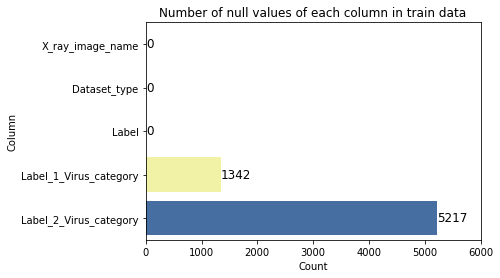

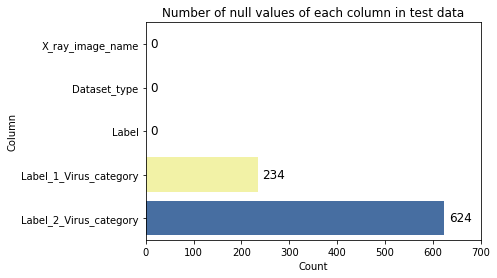

In [14]:
def count_plot_null_value(dataset, xticks):
    fig = plt.figure()
    if dataset == 'train':
        dataset_df = train_df
    else:
        dataset_df = test_df
    ax = sns.barplot(x=dataset_df.isnull().sum(), 
                     y=dataset_df.columns,
                     order=['X_ray_image_name', 'Dataset_type', 'Label', 'Label_1_Virus_category', 'Label_2_Virus_category'],
                     palette="Accent")
    ax.set_xticks(xticks)
    ax.set_ylabel('Column')
    ax.set_xlabel('Count')
    ax.set_title(f'Number of null values of each column in { dataset } data')

    # Add text to chart
    for p in ax.patches:
        ax.annotate(int(p.get_width()),
                    (p.get_width() + 10, p.get_y() + p.get_height() / 2),
                    va='center',
                    size=12)
    plt.show()
        
count_plot_null_value('train', np.arange(0, 7000, 1000))
count_plot_null_value('test', np.arange(0, 750, 100))

In [15]:
# fill na
train_df.fillna('unknow', inplace=True)
test_df.fillna('unknow', inplace=True)

count value in Label Column

In [16]:
def count_plot_value_in_column(column, dataset, ax, order=None):
    ax = sns.countplot(y=column, 
                       data=dataset, 
                       palette='Accent',
                       ax=ax,
                       order=order)
    return ax

def add_annotate_to_chart(ax):
    for p in ax.patches:
        ax.annotate(int(p.get_width()),
                    (p.get_width() + 10, p.get_y() + p.get_height() / 2),
                    va='center',
                    size=12)

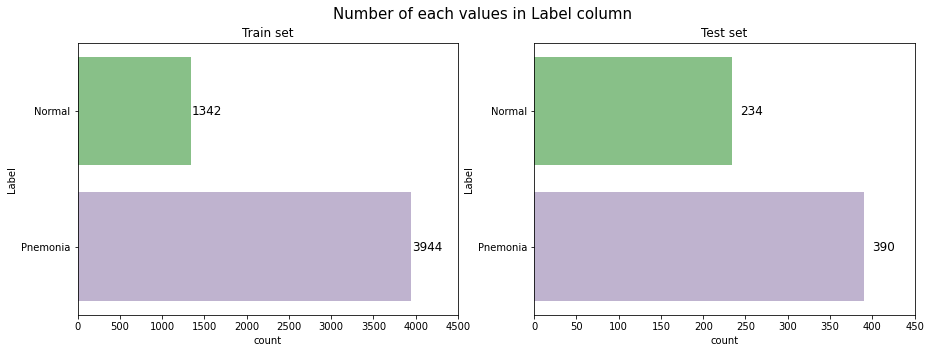

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Train set
ax = count_plot_value_in_column('Label', train_df, axs[0])
ax.set_xticks(np.arange(0, 5000, 500))
ax.set_title('Train set')
add_annotate_to_chart(ax)

# Test set
ax = count_plot_value_in_column('Label', test_df, axs[1])
ax.set_xticks(np.arange(0, 500, 50))
ax.set_title('Test set')
add_annotate_to_chart(ax)

fig.suptitle('Number of each values in Label column', size=15)
plt.show()

Make sure that all normal cases go with unknow value in Label_1_Virus_category and Label_2_Virus_category

In [18]:
train_normal = train_df[train_df.Label == 'Normal']
test_normal = test_df[test_df.Label == 'Normal']

train_normal_with_unknow = train_normal[(train_normal.Label_1_Virus_category == 'unknow') & (train_normal.Label_2_Virus_category == 'unknow')]
test_normal_with_unknow = test_normal[(test_normal.Label_1_Virus_category == 'unknow') & (test_normal.Label_2_Virus_category == 'unknow')]

total_normal_cases = train_normal.shape[0] + test_normal.shape[0]
total_normal_with_unknow_cases = train_normal_with_unknow.shape[0] + test_normal_with_unknow.shape[0]

print(f'Label = Normal: { total_normal_cases }')
print(f"Label = Normal & Label_1 = unknow & Label_2 = unknow: { total_normal_with_unknow_cases }")

assert total_normal_cases + total_normal_with_unknow_cases

Label = Normal: 1576
Label = Normal & Label_1 = unknow & Label_2 = unknow: 1576


Count value in Label_1_Virus_category column

In [19]:
train_pnemonia = train_df[~train_df.index.isin(train_normal.index)]
test_pnemonia = test_df[~test_df.index.isin(test_normal.index)]

assert train_pnemonia.shape[0] + train_normal.shape[0] == train_df.shape[0]
assert test_pnemonia.shape[0] + test_normal.shape[0] == test_df.shape[0]

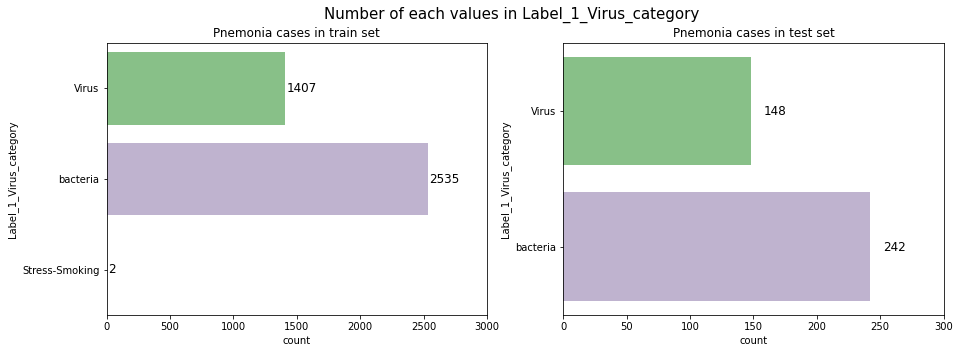

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Train pnemonia
ax = count_plot_value_in_column('Label_1_Virus_category', 
                                train_pnemonia, 
                                axs[0])
ax.set_xticks(np.arange(0, 3500, 500))
ax.set_title('Pnemonia cases in train set')
add_annotate_to_chart(ax)

# Test pnemonia
ax = count_plot_value_in_column('Label_1_Virus_category',
                                test_pnemonia,
                                axs[1])
ax.set_xticks(np.arange(0, 350, 50))
ax.set_title('Pnemonia cases in test set')
add_annotate_to_chart(ax)

fig.suptitle('Number of each values in Label_1_Virus_category', size=15)

plt.show()

Count value in Label_2_Virus_category column

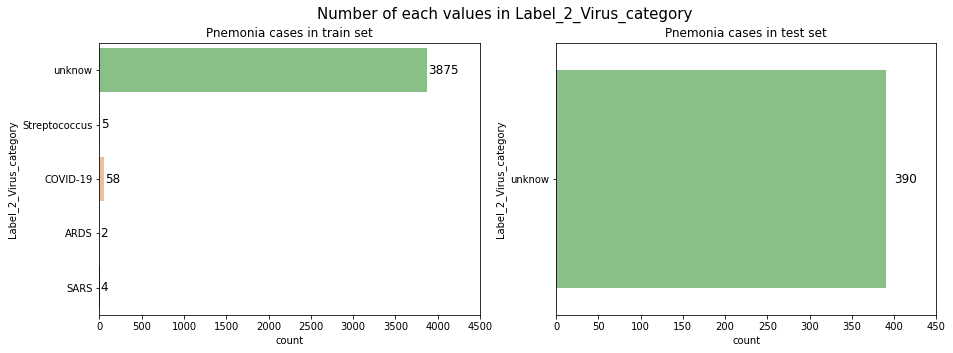

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Train pnemonia
ax = count_plot_value_in_column('Label_2_Virus_category', 
                                train_pnemonia, 
                                axs[0])
ax.set_xticks(np.arange(0, 5000, 500))
ax.set_title('Pnemonia cases in train set')
add_annotate_to_chart(ax)

# Test pnemonia 
ax = count_plot_value_in_column('Label_2_Virus_category', test_pnemonia, axs[1])
ax.set_xticks(np.arange(0, 500, 50))
ax.set_title('Pnemonia cases in test set')
add_annotate_to_chart(ax)

fig.suptitle('Number of each values in Label_2_Virus_category', size=15)

plt.show()

Inference from charts


1.   We have 2 cases that is Pnemonia and Normal case.
2.   Pnemonia cases is much more than Normal cases in both train set and test set.
3.   All Normal cases is labeled as unknow/null in Label_1_Virus_category and Label_2_Virus_category.
4.   All Pnemonia cases is labeled as bacteria, virus, stress-smoking and dont have any unknow/null value in Label_1_Virus_category in both train set and test set.
5.   In train set, most of pnemonia case is labeled as unknow/null value (3875/3944).
6. In test set, all pnemonia case is labels as unknow/null value.
7. In Label_1_Virus_category, those value are different to much.
8.   In Label_2_Virus_category, if we remove all unknow value then we just have 69 sample.
9. Thus we are going to construct a model which classifies Normal and Pnemonia cases.
10. Cause the difference of Pnemonia and Normal cases so that we should use AUC or F1 score to evaluate the goodness of model.


## Visualization

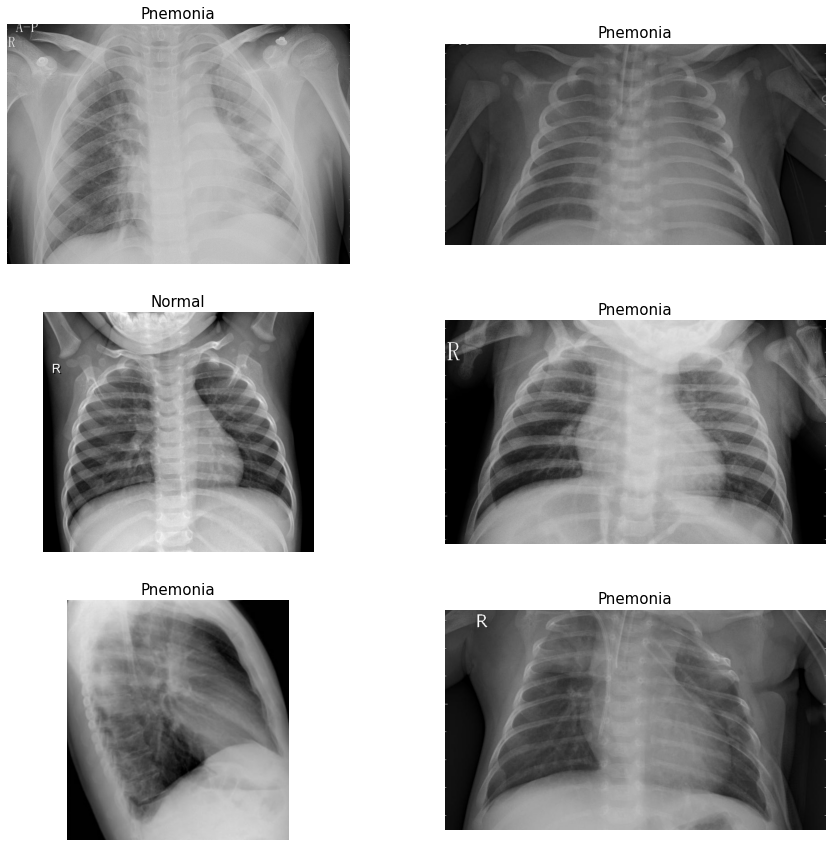

In [22]:
# plot random 6 images in train dataset
assert os.path.exists(train_img_folder)
assert os.path.exists(test_img_folder)

random_train_img = train_df.sample(6).reset_index(drop=True)

fig = plt.figure(figsize=(15, 15))
for i in range(6):
    ax = plt.subplot(3, 2, i+1)
    img_path = os.path.join(train_img_folder, random_train_img.loc[i, 'X_ray_image_name'])
    label = random_train_img.loc[i, 'Label']
    img = load_img(img_path)
    ax.axis('off')
    ax.set_title(label, size=15)
    ax.imshow(img)
    
plt.show()

## Image histogram
An image histogram is a type of histogram that acts as a graphical representation of the tonal distribution in a digital image. It plots the number of pixels for each tonal value. By looking at the histogram for a specific image a viewer will be able to judge the entire tonal distribution at a glance.


Image Histogram of 5 normal cases

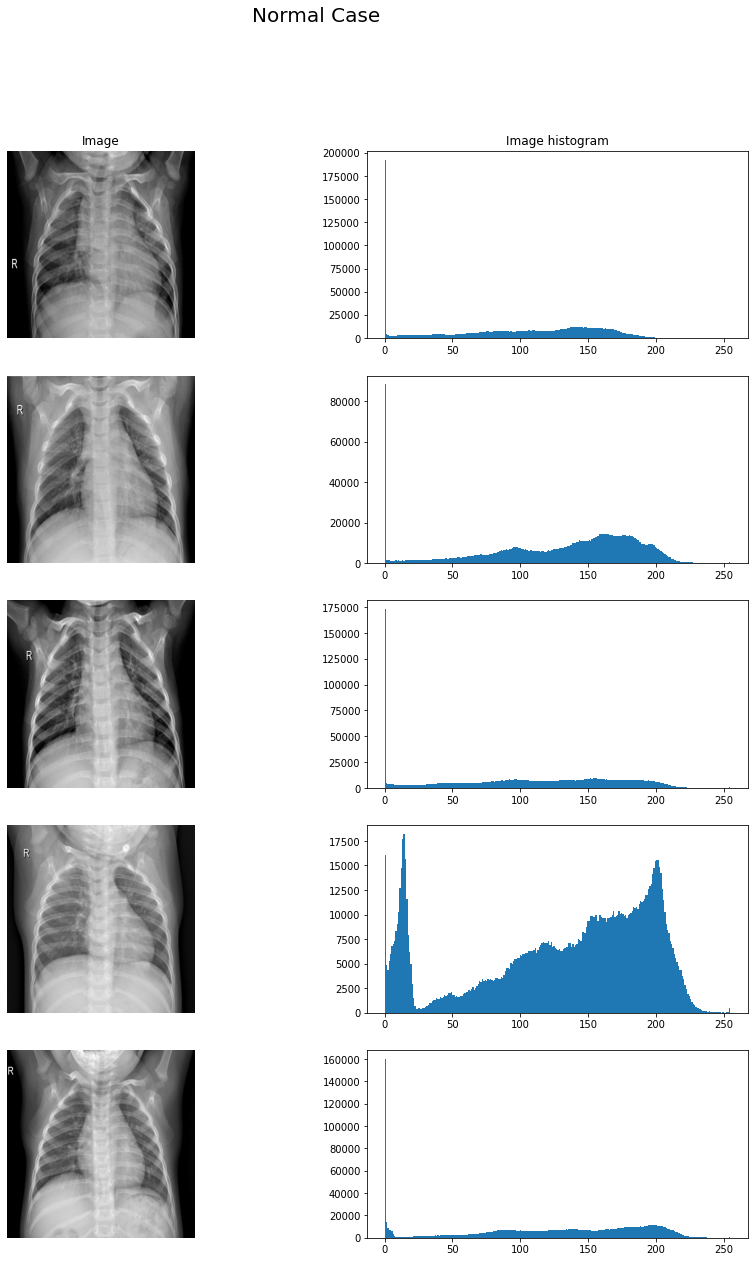

In [23]:
normal_case_img_name = train_df[train_df.Label == 'Normal'].X_ray_image_name[:5]

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
for idx, img_name in enumerate(normal_case_img_name):
    # Plot image
    img_path = os.path.join(train_img_folder, img_name)
    img = load_img(img_path)
    img = img.resize((700, 700))
    axs[idx, 0].imshow(img)
    axs[idx, 0].axis('off')
    # Plot image histogram
    img_arr = img_to_array(img)
    axs[idx, 1].hist(img_arr.ravel(), 256)
    
axs[0, 0].set_title('Image')    
axs[0, 1].set_title('Image histogram')
fig.suptitle('Normal Case', size = 20)
plt.show()

Image Histogram of 5 pneumonia cases

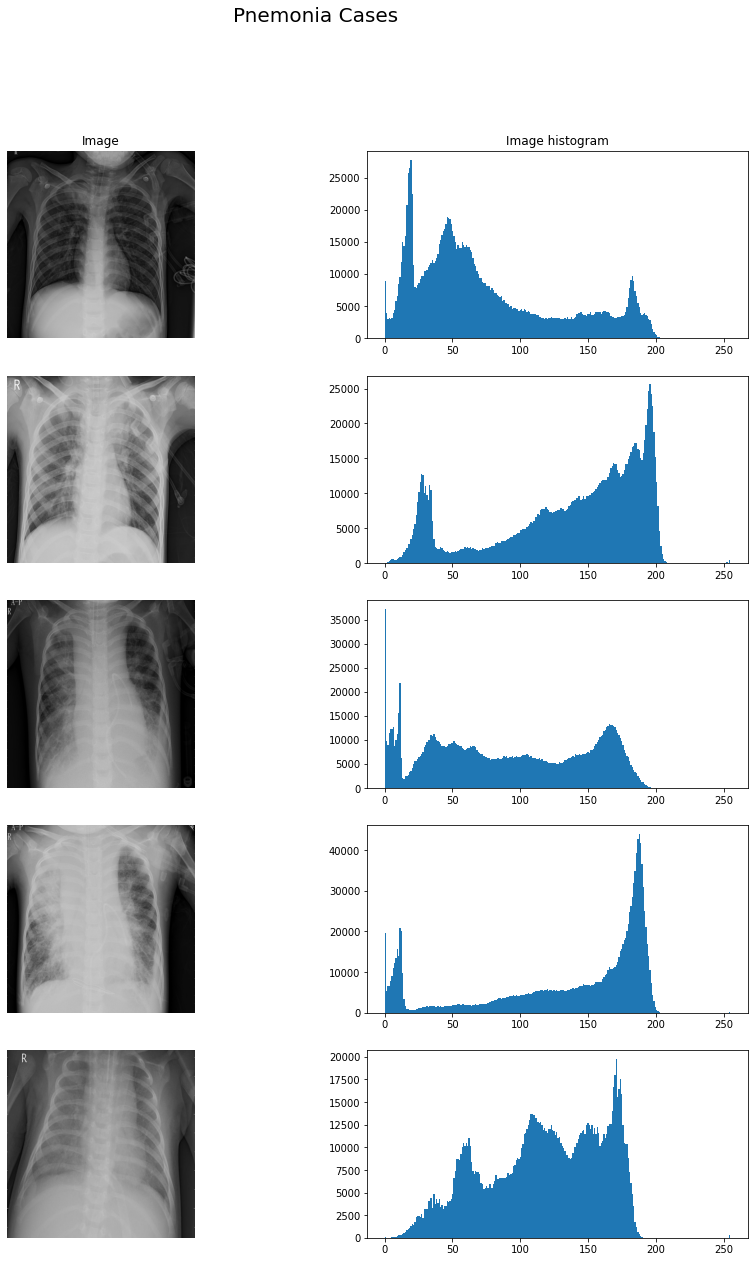

In [24]:
pnemonia_case_img_name = train_df[train_df.Label == 'Pnemonia'].X_ray_image_name[:5]

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
for idx, img_name in enumerate(pnemonia_case_img_name):
    # Plot image
    img_path = os.path.join(train_img_folder, img_name)
    img = load_img(img_path)
    img = img.resize((700, 700))
    axs[idx, 0].imshow(img)
    axs[idx, 0].axis('off')
    # Plot image histogram
    img_arr = img_to_array(img)
    axs[idx, 1].hist(img_arr.ravel(), 256)

axs[0, 0].set_title('Image')
axs[0, 1].set_title('Image histogram')
fig.suptitle('Pnemonia Cases', size=20)
plt.show()

# Data Preperation

## Augmentation

In [25]:
def load_img_path(quantity, dataset):
    if dataset == 'train':
        df = train_df
        folder = train_img_folder
    elif dataset == 'test':
        df = test_df
        folder = test_img_folder
    if quantity <= 0:
        return None
    img_names = df.X_ray_image_name[:quantity]
    img_paths = [os.path.join(folder, img_name) for img_name in img_names]
    return img_paths

def img_path_to_array(img_paths):
    img_arr = [img_to_array(load_img(img_path).resize((500, 500))) for img_path in tqdm(img_paths)]
    img_arr = np.array(img_arr)
    return img_arr

def show_img(img):
    plt.imshow(array_to_img(img))
    
def show_multi_img(img_arr):
    fig = plt.figure(figsize=(20,10))
    for i in range(len(img_arr)):
        plt.subplot(len(img_arr) / 4, 4, i+1)
        show_img(img_arr[i])
        plt.axis('off')

In [26]:
train_datagen = ImageDataGenerator(rotation_range=10,
                              brightness_range=(0.1, 1.2),
                              horizontal_flip=True,
                              zoom_range=[0.75, 1])
test_datagen = ImageDataGenerator()

Plot images after Augmentation

In [27]:
img_paths = load_img_path(100, 'train')
img_arr = img_path_to_array(img_paths)

100%|██████████| 100/100 [00:05<00:00, 19.21it/s]


In [28]:
aug_imgs = train_datagen.flow(img_arr ,batch_size=8)
print(f'Number of batches: { len(aug_imgs) }')

Number of batches: 13


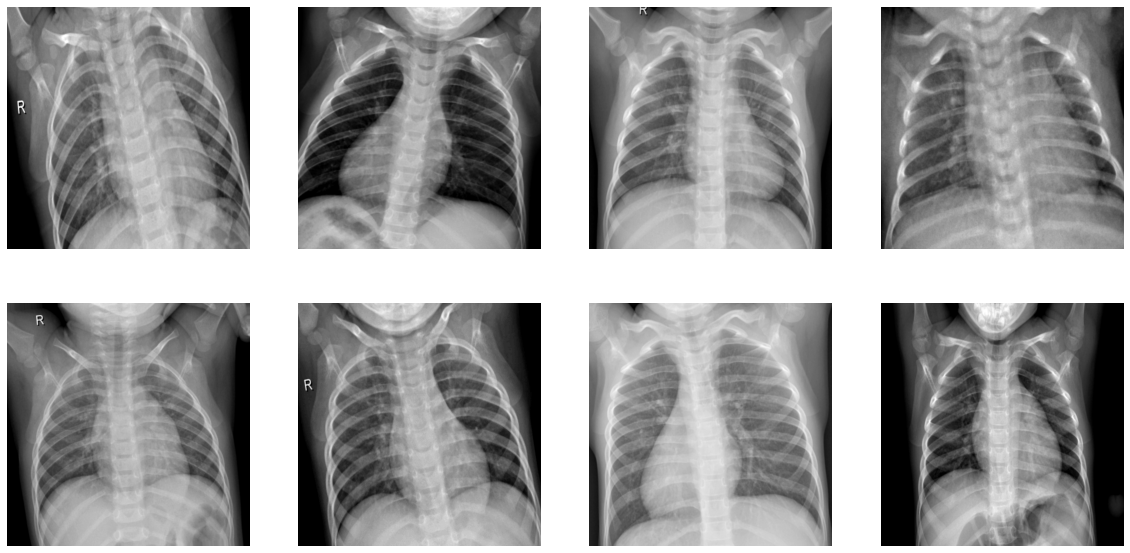

In [29]:
# augmented Images
show_multi_img(aug_imgs[0])

## Train-Test split

In [30]:
train_datagen = ImageDataGenerator(rotation_range=10,
                              brightness_range=(0.8, 1.2),
                              zoom_range=[0.75, 1],
                              horizontal_flip=True)
test_datagen = ImageDataGenerator()

In [31]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)

In [32]:
train_batches = train_datagen.flow_from_dataframe(train_df,
                                             directory=train_img_folder,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             class_mode='binary',
                                             batch_size=128)

valid_batches = test_datagen.flow_from_dataframe(valid_df,
                                             directory=train_img_folder,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             class_mode='binary',
                                             batch_size=128)

test_batches = test_datagen.flow_from_dataframe(test_df,
                                            directory=test_img_folder,
                                            x_col='X_ray_image_name',
                                            y_col='Label',
                                            class_mode='binary',
                                            batch_size=8,
                                            shuffle=False)

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [33]:
print(f'Label encode: { valid_batches.class_indices }')

Label encode: {'Normal': 0, 'Pnemonia': 1}


In [34]:
train_batches_series = pd.Series(train_batches.classes)
valid_batches_series = pd.Series(valid_batches.classes)

print(f'Value count in train_batches: \n{ train_batches_series.value_counts() }')
print(f'Value count in valid_batches: \n{ valid_batches_series.value_counts() }')

Value count in train_batches: 
1    3169
0    1059
dtype: int64
Value count in valid_batches: 
1    775
0    283
dtype: int64


## Fine Tuning

In [35]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        
create_dir('models')

## Preprocessing Layer

In [36]:
resize_and_rescale = Sequential([
    Resizing(224, 224),
    Rescaling(1./255)
])

# Fitting Model 

In [37]:
metrics = [TruePositives(name='TP'),
           TrueNegatives(name='TN'),
           FalsePositives(name='FP'),
           FalseNegatives(name='FN'),
           AUC(curve='PR', name='AUC')]

In [38]:
#!pip install git+https://github.com/qubvel/classification_models.git

In [39]:
#using mobinet_v2
INPUT_SHAPE = (224,224,3) 

#get the pretrained model
base_model = tf.keras.applications.MobileNetV2(input_shape= INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()
# from classification_models.keras import Classifiers

# ResNet18, preprocess_input = Classifiers.get('resnet18')
# base_model = ResNet18((224, 224, 3), include_top=False)

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [40]:
# Preprocess layer
ft_mobilenet = Sequential([resize_and_rescale]) 
# Feature extractor
ft_mobilenet.add(base_model)
# Classifier
ft_mobilenet.add(Dense(128))
ft_mobilenet.add(Dropout(0.2))
ft_mobilenet.add(GlobalAveragePooling2D())
ft_mobilenet.add(Dense(1, activation='sigmoid'))


In [41]:
# Freeze
#for layer in ft_resnet34.layers[1].layers[:50]:
#    layer.trainable = False

In [42]:
mobilenet_dir = 'models/mobilenet'
mobilenet_file = 'best_mobilenet.hdf5'

create_dir(mobilenet_dir)

checkpoint = ModelCheckpoint(os.path.join(mobilenet_dir, mobilenet_file),
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=30,
                               verbose=1,
                               restore_best_weights=True)

In [43]:
# # Initialize TensorBoard
# log_dir = 'models/resnet18/logs'
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [46]:
epochs = 50
learning_rate = 1e-4

ft_mobilenet.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=metrics)

training_time_start = datetime.datetime.now()

mobilenet_history = ft_mobilenet.fit(train_batches,
                                epochs=epochs,
                                verbose=2,
                                callbacks=[checkpoint, early_stopping],
                                validation_data=valid_batches,
                                steps_per_epoch=len(train_batches),
                                validation_steps=len(valid_batches))

training_time_end = datetime.datetime.now()

Epoch 1/50
34/34 - 141s - loss: 0.2596 - TP: 4114.0000 - TN: 1032.0000 - FP: 413.0000 - FN: 205.0000 - AUC: 0.9805 - val_loss: 0.2474 - val_TP: 679.0000 - val_TN: 273.0000 - val_FP: 10.0000 - val_FN: 96.0000 - val_AUC: 0.9910

Epoch 00001: val_loss improved from 0.32689 to 0.24737, saving model to models/mobilenet/best_mobilenet.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
34/34 - 134s - loss: 0.2092 - TP: 3030.0000 - TN: 853.0000 - FP: 206.0000 - FN: 139.0000 - AUC: 0.9883 - val_loss: 0.1877 - val_TP: 718.0000 - val_TN: 265.0000 - val_FP: 18.0000 - val_FN: 57.0000 - val_AUC: 0.9927

Epoch 00002: val_loss improved from 0.24737 to 0.18773, saving model to models/mobilenet/best_mobilenet.hdf5
Epoch 3/50
34/34 - 133s - loss: 0.1915 - TP: 3012.0000 - TN: 880.0000 - FP: 179.0000 - FN: 157.0000 - AUC: 0.9905 - val_loss: 0.1742 - val_TP: 728.0000 - val_TN: 266.0000 - val_FP: 17.0000 - val_FN: 47.0000 - val_AUC: 0.9931

Epoch 00003: val_loss improved from 0.18773 to 0.17422, saving model to models/mobilenet/best_mobilenet.hdf5
Epoch 4/50
34/34 - 132s - loss: 0.1776 - TP: 3031.0000 - TN: 897.0000 - FP: 162.0000 - FN: 138.0000 - AUC: 0.9917 - val_loss: 0.1653 - val_TP: 726.0000 - val_TN: 267.0000 - val_FP: 16.0000 - val_FN: 49.0000 - val_AUC: 0.9938

Epoch 00004: val_loss improved from 0.17422 to 0.16532, saving model to models/mobilenet/best_mobilenet.

In [47]:
total_training_seconds = (training_time_end - training_time_start).seconds
print('Total training time: ', str(datetime.timedelta(seconds=total_training_seconds)))

Total training time:  1:48:07


In [48]:
from google.colab import files
files.download('/content/models/mobilenet/best_mobilenet.hdf5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# reload the model

In [49]:
#resnet101_history

In [50]:
#loaded_model

In [51]:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('/content/models/resnet101/best_resnet101.hdf5')
# loaded_model.summary()

# Evaluation

In [52]:
mobilenet_hist_df = pd.DataFrame(mobilenet_history.history)

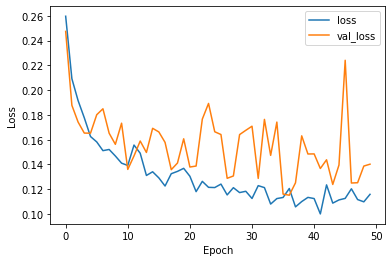

In [53]:
mobilenet_hist_df.loc[:, ['loss', 'val_loss']].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

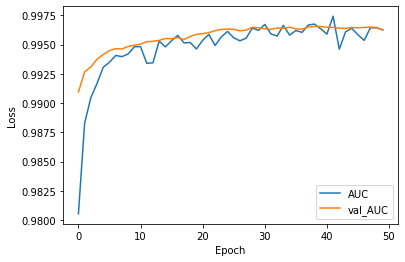

In [54]:
mobilenet_hist_df.loc[:, ['AUC', 'val_AUC']].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

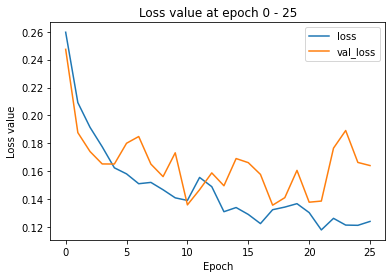

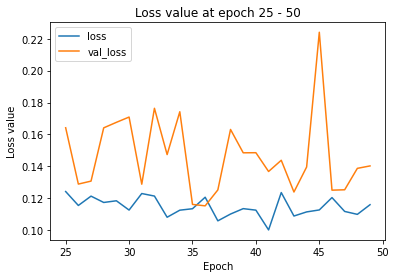

In [55]:
num_of_epochs = mobilenet_hist_df.shape[0]
half_epoch = int(num_of_epochs / 2)

first_half_mobilenet_hist = mobilenet_hist_df.loc[:half_epoch]
first_title = f'Loss value at epoch 0 - { half_epoch }'

last_half_mobilenet_hist = mobilenet_hist_df.loc[half_epoch:len(mobilenet_hist_df)]
last_title = f'Loss value at epoch { half_epoch } - { len(mobilenet_hist_df) }'

hists = [first_half_mobilenet_hist, last_half_mobilenet_hist]
titles = [first_title, last_title]

for i in range(2):
    ax = hists[i][['loss', 'val_loss']].plot()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss value')
    ax.set_title(titles[i])
plt.show()

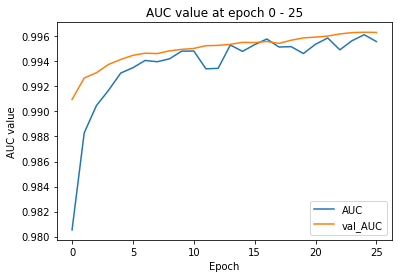

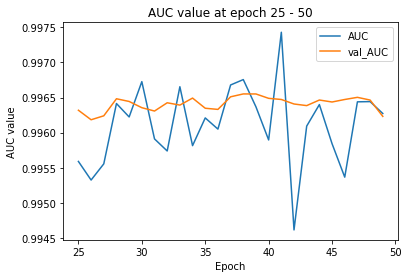

In [56]:
first_title = f'AUC value at epoch 0 - { half_epoch }'
last_title = f'AUC value at epoch { half_epoch } - { len(mobilenet_hist_df) }'

titles = [first_title, last_title]

for i in range(2):
    ax = hists[i][['AUC', 'val_AUC']].plot()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC value')
    ax.set_title(titles[i])
plt.show()

In [57]:
evaluate_mobilenet = ft_mobilenet.evaluate(test_batches, verbose=1)

78/78 [==============================] - 8s 96ms/step - loss: 0.2647 - TP: 375.0000 - TN: 184.0000 - FP: 50.0000 - FN: 15.0000 - AUC: 0.9786


In [58]:
#classification_report

In [66]:
loss, tp, tn, fp, fn, auc = evaluate_mobilenet[0], evaluate_mobilenet[1], evaluate_mobilenet[2], evaluate_mobilenet[3], evaluate_mobilenet[4], evaluate_mobilenet[5]
print(f'Test loss: { loss }')
print(f'True positive: { tp }')
print(f'True negative: { tn }')
print(f'False positive: { fp }')
print(f'False negative: { fn }')
print('AUC: %.4f' % auc)

Test loss: 0.26471996307373047
True positive: 375.0
True negative: 184.0
False positive: 50.0
False negative: 15.0
AUC: 0.9786


## Precision Recall Curve & best threshold

In [60]:
def find_optimal_threshold(precision, recall, threshold):
    f1_score = (2 * precision * recall) / (precision + recall)
    best_idx = np.argmax(f1_score)
    best_threshold = threshold[best_idx]
    return best_threshold, best_idx

In [61]:
y_true = test_batches.classes
y_predict = ft_mobilenet.predict(test_batches)
precision, recall, threshold = precision_recall_curve(y_true, y_predict)
best_threshold, best_idx = find_optimal_threshold(precision, recall, threshold)
print('Best threshold: {}'.format(best_threshold))

Best threshold: 0.722793459892273


roc curve

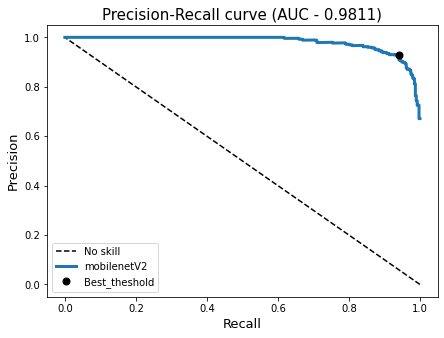

In [62]:
import numpy as np
from sklearn import metrics
plt.figure(figsize=(7, 5))
auc_score = metrics.auc(recall, precision) #==> 0.979880213737487
plt.plot([1, 0], [0, 1], linestyle='--', color='black', label='No skill')
plt.plot(recall, precision, linewidth=3, label='mobilenetV2')
plt.plot(recall[best_idx], precision[best_idx], 
         marker='o', color='black', 
         label='Best_theshold', linestyle='', markersize='7')
plt.xlabel('Recall', size=13)
plt.ylabel('Precision', size=13)
plt.title('Precision-Recall curve (AUC - {:.4f})'.format(auc_score), size=15)
plt.legend()
plt.show()


# plt.figure(figsize=(7, 5))
# auc_score = auc(recall, precision)
# plt.plot([1, 0], [0, 1], linestyle='--', color='black', label='No skill')
# plt.plot(recall, precision, linewidth=3, label='ResNet18')
# plt.plot(recall[best_idx], precision[best_idx], 
#          marker='o', color='black', 
#          label='Best_theshold', linestyle='', markersize='7')
# plt.xlabel('Recall', size=13)
# plt.ylabel('Precision', size=13)
# plt.title('Precision-Recall curve (AUC - {:.4f})'.format(auc_score), size=15)
# plt.legend()
# plt.show()
# '''

## Predict and Confusion Metricx

In [63]:
y_predict = (y_predict >= best_threshold).astype('int')
y_predict = np.reshape(y_predict, -1)

In [64]:
cfs_matrix = confusion_matrix(y_true, y_predict)

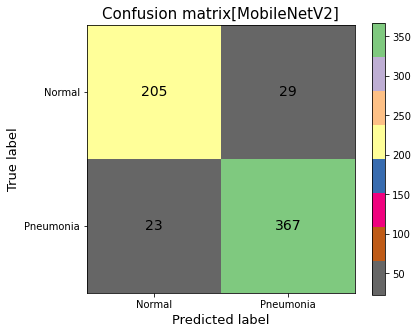

In [65]:
label = ['Normal', 'Pneumonia']

plt.figure(figsize=(6, 5))
plt.imshow(cfs_matrix, cmap=plt.cm.Accent_r)
plt.colorbar()
for i in range(len(label)):
    for j in range(len(label)):
        plt.text(j, i, cfs_matrix[i, j],
                 horizontalalignment='center', verticalalignment='center', size=14)
plt.xticks(np.arange(len(label)), label)
plt.yticks(np.arange(len(label)), label)
plt.xlabel('Predicted label', size=13)
plt.ylabel('True label', size=13)
plt.title('Confusion matrix[MobileNetV2]', size=15)
plt.show()